In [1]:
!pip install alpha_vantage

In [2]:
import pandas as pd

url_conf_cases = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

df_conf_cases_initial = pd.read_csv(url_conf_cases)
df_deaths_initial = pd.read_csv(url_deaths)

#converting date columns to datetime format
date_columns = df_conf_cases_initial.columns[4:]
date_range = pd.to_datetime(date_columns)

# getting data from February 2020 to August 2021
mask = (date_range >= '2020-02-01') & (date_range <= '2021-08-31')
df_conf_cases = df_conf_cases_initial.iloc[:, :4].join(df_conf_cases_initial.iloc[:, 4:][date_columns[mask]])
df_deaths = df_deaths_initial.iloc[:, :4].join(df_deaths_initial.iloc[:, 4:][date_columns[mask]])

# Global level sum of confirmed cases and deaths
global_confirmed = df_conf_cases.iloc[:, 4:].sum(axis=0)
global_deaths = df_deaths.iloc[:, 4:].sum(axis=0)

# Global aggregated dataframe
global_df = pd.DataFrame({
    'Date': global_confirmed.index,
    'Confirmed Cases': global_confirmed.values,
    'Deaths': global_deaths.values
})

# confirmed cases and deaths per day as we are getting compound numbers by default
global_df['Confirmed Cases Updated'] = global_df['Confirmed Cases'].diff().fillna(global_df['Confirmed Cases'])
global_df['Deaths Updated'] = global_df['Deaths'].diff().fillna(global_df['Deaths'])

print(global_df)

        Date  Confirmed Cases   Deaths  Confirmed Cases Updated  \
0     2/1/20            12038      260                  12038.0   
1     2/2/20            16787      364                   4749.0   
2     2/3/20            19887      428                   3100.0   
3     2/4/20            23899      494                   4012.0   
4     2/5/20            27644      566                   3745.0   
..       ...              ...      ...                      ...   
573  8/27/21        215988154  4513136                 751123.0   
574  8/28/21        216545334  4521572                 557180.0   
575  8/29/21        216992164  4528394                 446830.0   
576  8/30/21        217664015  4537965                 671851.0   
577  8/31/21        218284677  4547280                 620662.0   

     Deaths Updated  
0             260.0  
1             104.0  
2              64.0  
3              66.0  
4              72.0  
..              ...  
573         10417.0  
574          8436.0

In [3]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries

API_Key = 'UMHFZK1BELSE4DD0'
ts = TimeSeries(key=API_Key, output_format='pandas')

# Function to retrieve and filter stock data
def get_filtered_stock_data(symbol, start_date, end_date):
    data, meta_data = ts.get_daily(symbol, outputsize='full')

    mask = (data.index >= start_date) & (data.index <= end_date)
    filtered_data = data.loc[mask]

    filtered_data = filtered_data.sort_index()
    return filtered_data[['2. high', '3. low']]



stocks = ['FSV.TO', 'IBM', 'DAL']

# Retrieve and append stock data
for stock_symbol in stocks:
    stock_data = get_filtered_stock_data(stock_symbol, '2020-02-01', '2021-08-31')

    # Rename columns to avoid conflicts
    stock_data.columns = [f'High_{stock_symbol}', f'Low_{stock_symbol}']

    # Making the 'Date' columns the same data type
    stock_data['Date'] = pd.to_datetime(stock_data.index)
    global_df['Date'] = pd.to_datetime(global_df['Date'])

    # Merge only the additional columns without duplicating existing ones
    global_df = pd.merge(
        global_df,
        stock_data,
        on=['Date'],
        how='outer',
        suffixes=('', f'_{stock_symbol}')  # Add suffix only for the additional columns
    )

# Drop duplicate 'Date' columns
global_df = global_df.loc[:, ~global_df.columns.duplicated()]

selected_columns = ['Date', 'Confirmed Cases', 'Deaths', 'Confirmed Cases Updated', 'Deaths Updated',
                     'High_FSV.TO', 'Low_FSV.TO', 'High_IBM', 'Low_IBM', 'High_DAL', 'Low_DAL']

global_df = global_df[selected_columns]

# global_df.iloc[:,[0, 3, 4, 6, 7, 11, 12, 16, 17]]

# Drop rows with any missing values
global_df = global_df.dropna()

global_df.to_csv('global_data.csv', index=False)

print(global_df)


          Date  Confirmed Cases   Deaths  Confirmed Cases Updated  \
2   2020-02-03            19887      428                   3100.0   
3   2020-02-04            23899      494                   4012.0   
4   2020-02-05            27644      566                   3745.0   
5   2020-02-06            30806      636                   3162.0   
6   2020-02-07            34400      721                   3594.0   
..         ...              ...      ...                      ...   
571 2021-08-25        214500582  4491128                 737411.0   
572 2021-08-26        215237031  4502719                 736449.0   
573 2021-08-27        215988154  4513136                 751123.0   
576 2021-08-30        217664015  4537965                 671851.0   
577 2021-08-31        218284677  4547280                 620662.0   

     Deaths Updated  High_FSV.TO  Low_FSV.TO  High_IBM  Low_IBM  High_DAL  \
2              64.0      132.790      130.17   147.280  143.900   57.2500   
3              66

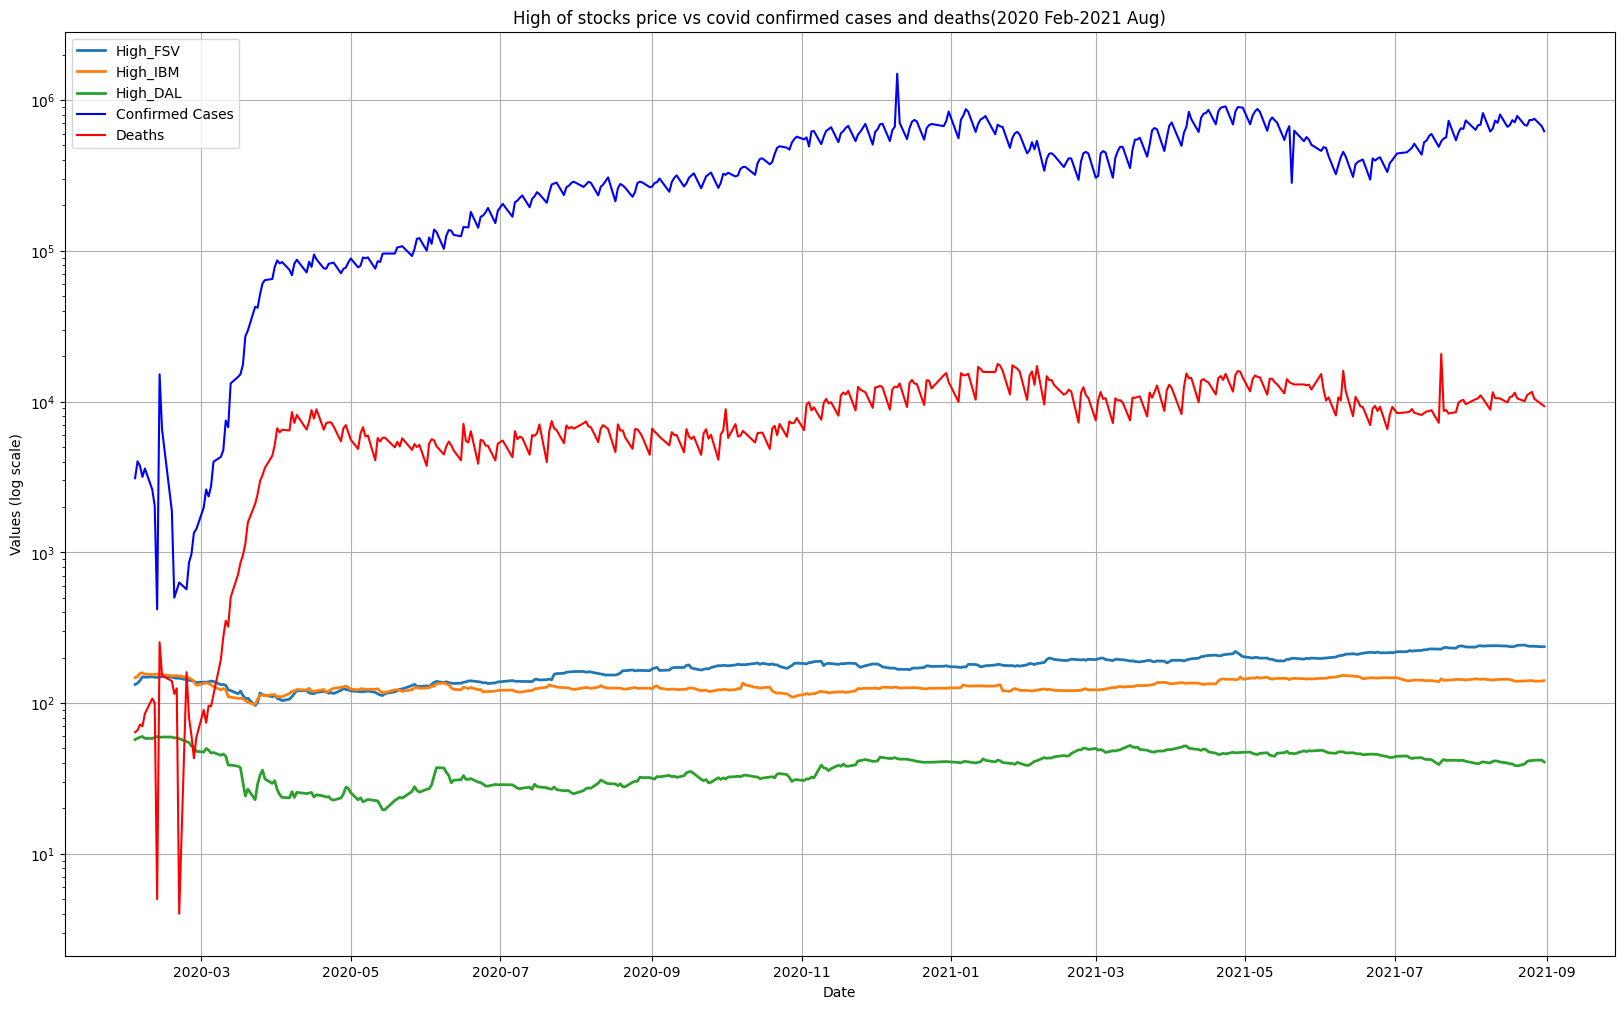

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

date_column = 'Date'
category1_column = 'High_FSV.TO'
category2_column = 'High_IBM'
category3_column = 'High_DAL'
category4_column = 'Confirmed Cases Updated'
category5_column = 'Deaths Updated'


plt.figure(figsize=(20, 12))

plt.plot(global_df[date_column], global_df[category1_column], label='High_FSV', linewidth=2)
plt.plot(global_df[date_column], global_df[category2_column], label='High_IBM', linewidth=2)
plt.plot(global_df[date_column], global_df[category3_column], label='High_DAL', linewidth=2)

#logarithmic scale for the y-axis
plt.yscale('log')


plt.plot(global_df[date_column], global_df[category4_column], label='Confirmed Cases', color='blue')
plt.plot(global_df[date_column], global_df[category5_column], label='Deaths', color='red')

plt.xlabel('Date')
plt.ylabel('Values (log scale)')
plt.title('High of stocks price vs covid confirmed cases and deaths(2020 Feb-2021 Aug)')
plt.legend()
plt.grid(True)
plt.show()
